## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Next, I'll perfome the distortion correction of test images.

In [2]:
# Make a list of calibration images
images = glob.glob('./img.png')
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    name=fname.split('/')[-1]
    cv2.imwrite('./output_images/img_undistorted.png',dst)
    #cv2.imshow('dist',dst)
    #cv2.waitKey(500)
#cv2.destroyAllWindows()

## Next, I'll implement color and gradient threshold

In [3]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh_tweak(img_f, sobel_kernel=15,orient='x', thresh_min=24, thresh_max=255):
    img = cv2.imread(img_f)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(binary_output)
    # Return the result
    return binary_output

def abs_sobel_thresh(gray, sobel_kernel=15,orient='x', thresh_min=10, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output

<function __main__.abs_sobel_thresh_tweak>

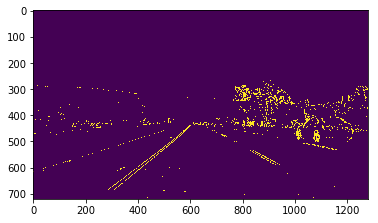

In [4]:
interact(abs_sobel_thresh_tweak,img_f='./sample2.png',sobel_kernel=(3,25,2),thresh_min=(1, 255),thresh_max=(1, 255))

<function __main__.abs_sobel_thresh_tweak>

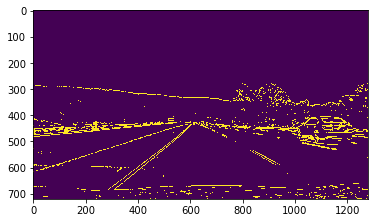

In [5]:
interact(abs_sobel_thresh_tweak,img_f='./sample2.png',orient='y',sobel_kernel=(3,25,2),thresh_min=(1, 255),thresh_max=(1, 255))

In [6]:

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thr(gray,sobel_kernel=15, mag_thresh_l=50,mag_thresh_h=160):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met   
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh_l) & (gradmag <= mag_thresh_h)] = 1

    # 6) Return this mask as your binary_output image
    #plt.imshow(binary_output)
    return binary_output

def mag_thr_tweak(img_f, sobel_kernel=15, mag_thresh_l=50,mag_thresh_h=160):
    img = cv2.imread(img_f)
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met   
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh_l) & (gradmag <= mag_thresh_h)] = 1

    # 6) Return this mask as your binary_output image
    plt.imshow(binary_output)
    return binary_output

<function __main__.mag_thr_tweak>

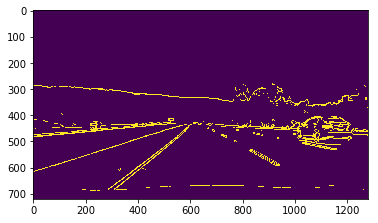

In [7]:
interact(mag_thr_tweak,img_f='sample2.png',mag_thresh_l=(0, 255),mag_thresh_h=(0, 255))

In [8]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold_tweak(img_f, sobel_kernel=15, dir_thresh_l =np.pi/4, dir_thresh_h=np.pi*3/4):
    img = cv2.imread(img_f)
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= dir_thresh_l) & (absgraddir <= dir_thresh_h)] = 1
    plt.imshow(binary_output)
    return binary_output


def dir_threshold(gray, sobel_kernel=15, dir_thresh_l =np.pi/4, dir_thresh_h=np.pi*3/4):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= dir_thresh_l) & (absgraddir <= dir_thresh_h)] = 1
    return binary_output

<function __main__.dir_threshold_tweak>

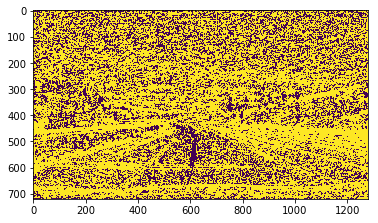

In [9]:
interact(dir_threshold_tweak,img_f='./sample.png',sobel_kernel=(3,25,2),dir_thresh_l=(0, np.pi),dir_thresh_h=(0, np.pi))

In [10]:
def combined_threshold(img):
    sobel_x = abs_sobel_thresh(img,orient='x')
    sobel_y = abs_sobel_thresh(img,orient='y')
    sobel_mag = mag_thr(img)
    #sobel_dir = dir_threshold(img)
    combined = np.zeros_like(sobel_x)
    #combined[((sobel_x == 1) & (sobel_y == 1)) | (sobel_mag == 1) ] = 1
    combined[((sobel_x == 1) & (sobel_y == 1))] = 1
    return combined
    


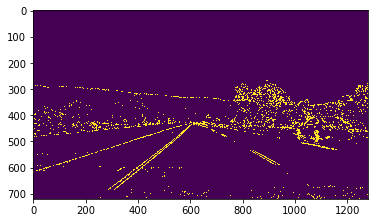

In [11]:
img = cv2.imread('./sample2.png')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]
#gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
comb = combined_threshold(l_channel)
plt.imshow(comb)

In [12]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img_f, s_thresh_l=90,s_thresh_h=255):
    img = cv2.imread(img_f)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_thresh_l) & (s_channel <= s_thresh_h)] = 1
    plt.imshow(binary_output)
    return binary_output

<function __main__.hls_select>

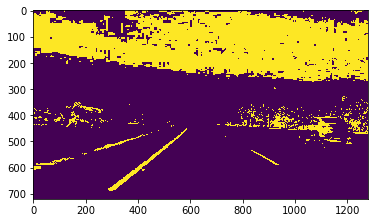

In [13]:
interact(hls_select,img_f='./sample2.png',s_thresh_l=(0,255),s_thresh_h=(0,255))

In [14]:
def pipeline(img, s_thresh=(170, 255)):
    img = np.copy(img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    comb = combined_threshold(l_channel)
    comb_s = combined_threshold(s_channel)
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (comb == 1) | (comb_s == 1)] = 1
    return combined_binary

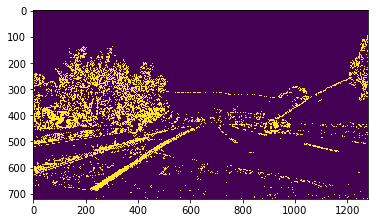

In [15]:
img = cv2.imread('./img.png')
output = pipeline(img)
#kernel = np.ones((3,3),np.uint8)
#opening = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)
output = output*255
cv2.imwrite('./output_images/img_threshold.png',output)
plt.imshow(output)

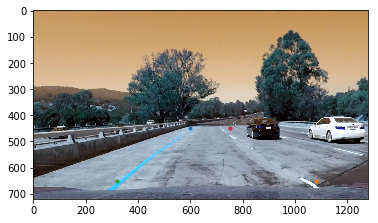

In [16]:
img = cv2.imread('./test_images/test1.jpg')
plt.imshow(img)
plt.plot(600,450,'.')
plt.plot(1080,650,'.')
plt.plot(320,650,'.')
plt.plot(750,450,'.')

In [17]:
def wrap(img,src,dst):
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

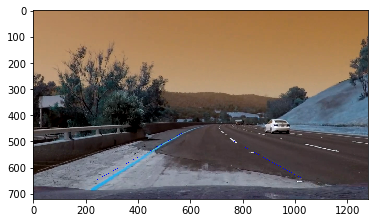

In [18]:
img = cv2.imread('./img.png')
offset_px=0
src = np.float32(
    [[img.shape[1]/2 - offset_px+70,img.shape[0]*0.65],
    [img.shape[1]/2 - offset_px+400,img.shape[0]*0.9],
    [img.shape[1]/2 - offset_px-400,img.shape[0]*0.9],
     [img.shape[1]/2 - offset_px-70,img.shape[0]*0.65]])
dst = np.float32(
    [[1030,100],
    [1030,720],
    [250,720],
     [250,100]])

w = wrap(img,src,dst)
src = src.reshape((-1,1,2))
img=cv2.polylines(img,[np.int32(src)],True,(0,0,255))
w=cv2.polylines(w,[np.int32(dst)],True,(0,0,255))
cv2.imwrite('orign_img.png',img)
cv2.imwrite('wraped_img.png',w)
plt.imshow(img)

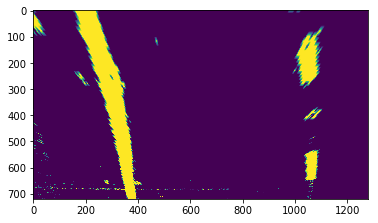

In [19]:
img = cv2.imread('sample.png')
output = pipeline(img)
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)
w = wrap(output,src,dst)
plt.imshow(w)

In [20]:
def close(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,15))
    closing = cv2.morphologyEx(output, cv2.MORPH_CLOSE, kernel)
    return closing

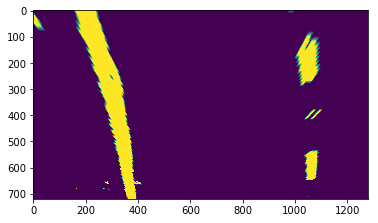

In [21]:
img = cv2.imread('sample.png')
output = pipeline(img)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)
w = wrap(opening,src,dst)
plt.imshow(w)

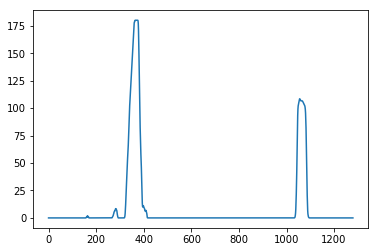

In [22]:
histogram = np.sum(w[w.shape[0]*3//4:,:], axis=0)
plt.plot(histogram)

In [23]:
def fitPoly(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_fit = None
    right_fit = None
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    # Extract left line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]    
    # Fit a second order polynomial to each
    if len(left_lane_inds)>3000:
        left_fit = np.polyfit(lefty, leftx, 2)

    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract right line pixel positions
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    if len(right_lane_inds)>3000:
        right_fit = np.polyfit(righty, rightx, 2)
    #plt.imshow(out_img)
    return left_fit,right_fit

In [24]:
 def fitPolyWithPrevInfo(binary_warped,prev_fit):
    if len(prev_fit) < 3:
        return None
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 300
    lane_inds = ((nonzerox > (prev_fit[0]*(nonzeroy**2) + prev_fit[1]*nonzeroy + prev_fit[2] - margin)) & (nonzerox < (prev_fit[0]*(nonzeroy**2) + prev_fit[1]*nonzeroy + prev_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    xPixels = nonzerox[lane_inds]
    yPixels = nonzeroy[lane_inds] 
    # Fit a second order polynomial to each
    if len(xPixels)>3000:
        poly_fit = np.polyfit(yPixels, xPixels, 2)
    else:
        poly_fit = None
    return poly_fit

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients of the last n fits of the line
        self.recent_fit =  np.empty((0,3), float)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        # Number of the iteration
        self.N=5
        
    def setPoly(self,poly,binary_warped):
        if poly is None:
            self.detected = False
        else:
            self.detected = True
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            # x values of the last n fits of the line
            np.append(self.recent_xfitted,poly[0]*ploty**2 + poly[1]*ploty + poly[2],axis = 0)
            if len(self.recent_xfitted) > self.N:
                self.recent_xfitted.pop(0)
            #average x values of the fitted line over the last n iterations
            self.bestx = np.average(self.recent_xfitted,axis = 0)
            #polynomial coefficients of the last n fits of the line
            self.recent_fit = np.r_[self.recent_fit,poly.reshape(1,-1)]
            #np.append(self.recent_fit,np.array([poly]),axis = 0)            
            #difference in fit coefficients between last and new fits
            #if len(self.recent_fit)>1:
            #    self.diffs = np.diff(self.recent_fit[-2],self.recent_fit[-1])
            if len(self.recent_fit) > self.N:
                self.recent_fit=np.delete(self.recent_fit,0,axis=0)
            #polynomial coefficients averaged over the last n iterations
            self.best_fit = np.average(self.recent_fit,axis = 0)  
            #polynomial coefficients for the most recent fit
            self.current_fit = poly
            
            
            # Define conversions in x and y from pixels space to meters
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension


            
            #x values for detected line pixels
            self.allx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
            #y values for detected line pixels
            self.ally = ploty
            
            # Fit new polynomials to x,y in world space
            fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
            # Calculate the new radii of curvature
            curverad = ((1 + (2*fit_cr[0]*ploty*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
            self.radius_of_curvature = np.average(curverad)
                     

In [ ]:
import imageio
from IPython.display import clear_output
filename = './project_video.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')
l = vid.get_length()
fps = vid.get_meta_data()['fps']
writer = imageio.get_writer('./test.mp4', fps=fps)
ResultWriter = imageio.get_writer('./result.mp4', fps=fps)
LeftLine = Line()
RightLine = Line()
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
offset_px=0
for frame in range(l):
    img = vid.get_data(frame)
    output = pipeline(img)
    kernel = np.ones((3,3),np.uint8)
    #offset_px=0
    #opening = cv2.morphologyEx(output, cv2.MORPH_OPEN, kernel)
    src = np.float32(
        [[img.shape[1]/2 - offset_px+70,img.shape[0]*0.65],
        [img.shape[1]/2 - offset_px+400,img.shape[0]*0.9],
        [img.shape[1]/2 - offset_px-400,img.shape[0]*0.9],
         [img.shape[1]/2 - offset_px-70,img.shape[0]*0.65]])
    dst = np.float32(
        [[1030,100],
        [1030,720],
        [250,720],
         [250,100]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = wrap(output,src,dst)
    left_fit ,right_fit = fitPoly(binary_warped)
    #left_fit = fitPolyWithPrevInfo(binary_warped,LeftLine.current_fit)
    #right_fit = fitPolyWithPrevInfo(binary_warped,RightLine.current_fit)
    #if left_fit is None or right_fit is None:
    #    print('searching from scratch')
    if left_fit is not None:
        LeftLine.setPoly(left_fit,binary_warped)
    else:
        print('Left is none')
    if right_fit is not None:
        RightLine.setPoly(right_fit,binary_warped)
    else:
        print('Left is none')
        
    if left_fit is None and right_fit is not None:
        LeftLine.setPoly(RightLine.current_fit,binary_warped)
    if right_fit is None and left_fit is not None:
        RightLine.setPoly(LeftLine.current_fit,binary_warped)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (LeftLine.best_fit[0]*(nonzeroy**2) + LeftLine.best_fit[1]*nonzeroy + LeftLine.best_fit[2] - margin)) & (nonzerox < (LeftLine.best_fit[0]*(nonzeroy**2) + LeftLine.best_fit[1]*nonzeroy + LeftLine.best_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (RightLine.best_fit[0]*(nonzeroy**2) + RightLine.best_fit[1]*nonzeroy + RightLine.best_fit[2] - margin)) & (nonzerox < (RightLine.best_fit[0]*(nonzeroy**2) + RightLine.best_fit[1]*nonzeroy + RightLine.best_fit[2] + margin)))  

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([LeftLine.allx-margin, LeftLine.ally]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([LeftLine.allx+margin, LeftLine.ally])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([RightLine.allx-margin, RightLine.ally]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([RightLine.allx+margin, RightLine.ally])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    LeftBottom=LeftLine.best_fit[0]*img.shape[0]**2 + LeftLine.best_fit[1]*img.shape[0] + LeftLine.best_fit[2]
    RightBottom=RightLine.best_fit[0]*img.shape[0]**2 + RightLine.best_fit[1]*img.shape[0] + RightLine.best_fit[2]
    CenterBottom=(RightBottom+LeftBottom)/2
    LeftLine.line_base_pos=(CenterBottom-LeftBottom)*xm_per_pix
    RightLine.line_base_pos=(RightBottom-CenterBottom)*xm_per_pix

    writer.append_data(result)
    #clear_output()
    print(frame,'/',l-1)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((binary_warped, binary_warped, binary_warped))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LeftLine.allx, LeftLine.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RightLine.allx, LeftLine.ally])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    img_np = np.asarray(img)
    img_float = img_np.astype(float)
    CombinedResult = cv2.addWeighted(img_float, 1, newwarp, 0.3, 0)
    
    radius=(LeftLine.radius_of_curvature + RightLine.radius_of_curvature)/2
    cv2.putText(CombinedResult,'Radius:'+str(radius),(50,30),cv2.FONT_HERSHEY_PLAIN,2,(255,255,0))
    
    offset=(CenterBottom - img.shape[1]/2)*xm_per_pix
    cv2.putText(CombinedResult,'Offset:'+str(offset),(50,60),cv2.FONT_HERSHEY_PLAIN,2,(255,255,0))
    ResultWriter.append_data(CombinedResult)
    #plt.imshow(CombinedResult)
    offset_px = img.shape[1]/2 -CenterBottom
    #CombinedResult=CombinedResult*255
    CombinedResult=np.uint8(CombinedResult)
    #CombinedResult.astype(int)
    CombinedResult=cv2.cvtColor(CombinedResult,cv2.COLOR_BGR2RGB)
    #cv2.imwrite('result.png',CombinedResult)
writer.close()
ResultWriter.close()



/home/saka1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/saka1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 / 1259
1 / 1259
2 / 1259
3 / 1259
4 / 1259
5 / 1259
6 / 1259
7 / 1259
8 / 1259
9 / 1259
10 / 1259
11 / 1259
12 / 1259
13 / 1259
14 / 1259
15 / 1259
16 / 1259
17 / 1259
18 / 1259
19 / 1259
20 / 1259
21 / 1259
22 / 1259
23 / 1259
24 / 1259
25 / 1259
26 / 1259
27 / 1259
28 / 1259
29 / 1259
30 / 1259
31 / 1259
32 / 1259
33 / 1259
34 / 1259
35 / 1259
36 / 1259
37 / 1259
38 / 1259
39 / 1259
40 / 1259
41 / 1259
42 / 1259
43 / 1259
44 / 1259
45 / 1259
46 / 1259
47 / 1259
48 / 1259
49 / 1259
50 / 1259
51 / 1259
52 / 1259
53 / 1259
54 / 1259
55 / 1259
56 / 1259
57 / 1259
58 / 1259
59 / 1259
60 / 1259
61 / 1259
62 / 1259
63 / 1259
64 / 1259
65 / 1259
66 / 1259
67 / 1259
68 / 1259
69 / 1259
70 / 1259
71 / 1259
72 / 1259
73 / 1259
74 / 1259
75 / 1259
76 / 1259
77 / 1259
78 / 1259
79 / 1259
80 / 1259
81 / 1259
82 / 1259
83 / 1259
84 / 1259
85 / 1259
86 / 1259
87 / 1259
88 / 1259
89 / 1259
90 / 1259
91 / 1259
92 / 1259
93 / 1259
94 / 1259
95 / 1259
96 / 1259
97 / 1259
98 / 1259
99 / 1259
100 / 1259